# Single Cell Sequencing
## Gene discovery exploration

Here we explore the traspose matrix, meaning how genes are close to each other. 

The idea is to explore genes that have similar expression, ergo could have similar funcionality (gene discovery procesure).

For that aim, we normalize each gene counting among cells between 0 and 1, and we reduce the dimensinality using umap transformation. Later we measure distance in the umap space (also could be done in the original space).

For measuring distance at first instance we are using euclidean distance. We have to explore different measures for similarity to check results and expand to other possibles genes. 

We use as an input adata file after quality control : campari_scs.h5ad

In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


## SECTION I: Data loading

Loading adata information that has been agregated and quality controled

In [36]:
figure_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\figuresR'
input_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\out'


adata_umap_path = os.path.join(input_path,'control_scs_umap_from_R.h5ad')
matlab_file_umap_export = "ilonas_genes_umap_1"

NO_PCA = 20

In [37]:
adata = ad.read_h5ad(adata_umap_path)
adata

AnnData object with n_obs × n_vars = 1706 × 15000
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## SECTION II: Analysis for gene discovery


In [38]:
# why normalize again? umap data was on normalized data...
# sc.pp.normalize_total(adata, target_sum=1e4)

In [39]:
x = adata.X
# stim = np.zeros((x.shape[0],))
# red = np.zeros((x.shape[0],))
# green = np.zeros((x.shape[0],))
# louvain = np.zeros((x.shape[0],6))

# for i in range(x.shape[0]):
#     stim[i] = adata.obs['stimulus'][i]
#     red[i] = adata.obs['red'][i]
#     green[i] = adata.obs['green'][i]

Text(0.5, 1.0, 'Normalization')

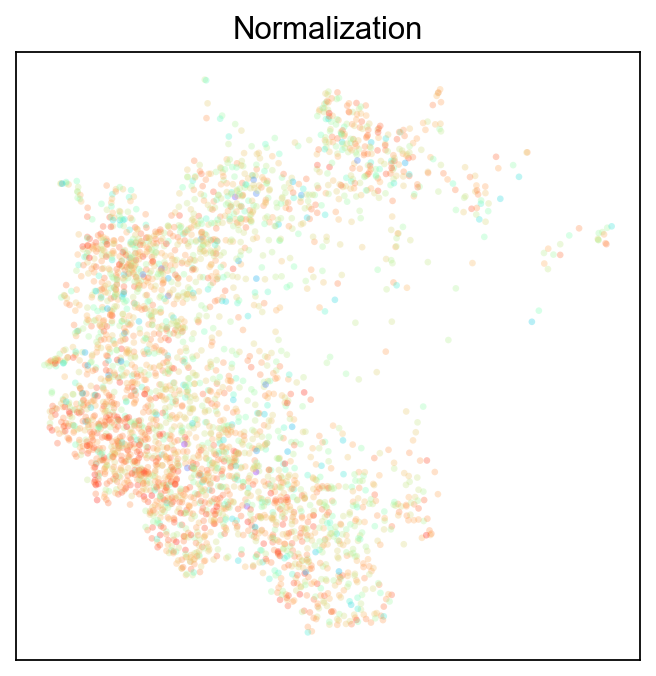

In [40]:
### create a umap embedding in the genes x genes space
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from scanpy._utils import NeighborsView


neighbors_key = 'neighbors'
neighbors = NeighborsView(adata, neighbors_key)
if 'params' not in neighbors or neighbors['params']['method'] != 'umap':
        logg.warning(
            f'.obsp["{neighbors["connectivities_key"]}"] have not been computed using umap'
        )
n_neighbors = neighbors['params']['n_neighbors']

scaled_data = StandardScaler().fit_transform(x)
scaled_data = (scaled_data.T - np.min(scaled_data, axis = 1))/ (np.max(scaled_data, axis = 1).reshape(-1) - np.min(scaled_data, axis = 1).reshape(-1))

pca1 = PCA(NO_PCA)
pca1.fit(scaled_data)
pca_embedding = pca1.transform(scaled_data)
reducer = umap.UMAP(n_components= 2,n_neighbors=n_neighbors,min_dist = 0.5,spread= 1.0, init= 'spectral', negative_sample_rate=5,
                    random_state= 0,verbose=sc.settings.verbosity > 3)
umap_embedding = reducer.fit_transform(pca_embedding)
expression_count = np.sum(x.T,axis = 1)
rcParams['figure.figsize']=(5,5)
figure, axes = plt.subplots(1,1)
axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')
axes.set_xticks([])
axes.set_yticks([])
axes.set_title('Normalization')


In [41]:
# # why repeat? why are plots different than the first time?
# figure, axes = plt.subplots(1,1)

# pca1 = PCA(NO_PCA)
# pca1.fit(scaled_data)
# pca_embedding = pca1.transform(scaled_data)
# reducer = umap.UMAP(n_components = 2)
# umap_embedding = reducer.fit_transform(pca_embedding)
# expression_count = np.sum(x.T,axis = 1)
# axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')
# axes.set_xticks([])
# axes.set_yticks([])
# axes.set_title('Normalization')
# figure.savefig(os.path.join(figure_path , 'genes_umap_expression_normed_campari_'+str(i)+'.png'))

In [46]:
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])

    
marker_genes = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
                'Bmpr1b','Nefh','Pvalb','Adm',
                'Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Chrna7','Chrna3',
                'P2rx3','Gfra2','Ldhb','Necab2','Spp1','Adra2a','Chrna7','Tafa4']

marker_position = np.zeros((len(marker_genes),))
count = 0
for marker in  marker_genes:
    index = gene_name.index(marker)
    marker_position[count] = index
    count = count+1

n = 20 # why n = 20? the 20 closest genes
nearest_neighbors = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance = np.zeros((n, len(marker_genes)))
auxiliar_distance = np.zeros((umap_embedding.shape[0]))

nearest_neighbors_cut = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance_cut = np.zeros((n, len(marker_genes)))
auxiliar_distance_cut = np.zeros((umap_embedding.shape[0]))

for i in range(len(marker_genes)):
    # a = umap_embedding[int(marker_position[i]),:] # one gene (distnace in umap space)
    a = x.T[int(marker_position[i]),:] # (distnace in normalized projection)
    for j in range(umap_embedding.shape[0]):
        # b = umap_embedding[j,:] # the other gene
        b = x.T[j,:]
        dist = np.linalg.norm(a-b)
        auxiliar_distance[j] = dist
    sorted_arguments = np.argsort(auxiliar_distance)
    nearest_neighbors_distance[:,i] = auxiliar_distance[sorted_arguments[0:n]]
    nearest_neighbors[:,i] = sorted_arguments[0:n].astype(int)

    
closest_genes = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors[j,i])])
    closest_genes.append(closest_genes_)

In [ ]:
#############################
# NEW MELISAS
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])

    
marker_genes = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
                'Bmpr1b','Nefh','Pvalb','Adm',
                'Trpm3','Piezo2','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Piezo2','Piezo1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Chrna7','Chrna3',
                'P2rx3','Gfra2','Ldhb','Necab2','Spp1','Adra2a','Chrna7','Tafa4']

marker_position = np.zeros((len(marker_genes),))
count = 0
for marker in  marker_genes:
    index = gene_name.index(marker)
    marker_position[count] = index
    count = count+1

n = 20
nearest_neighbors = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance = np.zeros((n, len(marker_genes)))
auxiliar_distance = np.zeros((umap_embedding.shape[0]))

nearest_neighbors_ = np.zeros((n, len(marker_genes)))
nearest_neighbors_distance_ = np.zeros((n, len(marker_genes)))
auxiliar_distance_ = np.zeros((umap_embedding.shape[0]))

for i in range(len(marker_genes)):
    a = umap_embedding[int(marker_position[i]),:]
    a_ = x.T[int(marker_position[i]),:]
    for j in range(umap_embedding.shape[0]):
        b = umap_embedding[j,:]
        b_ = x.T[j,:]
        dist = np.linalg.norm(a-b)
        auxiliar_distance[j] = dist
        dist_ = np.linalg.norm(a_-b_)
        auxiliar_distance_[j] = dist_
    sorted_arguments = np.argsort(auxiliar_distance)
    nearest_neighbors_distance[:,i] = auxiliar_distance[sorted_arguments[0:n]]
    nearest_neighbors[:,i] = sorted_arguments[0:n].astype(int)
    
    sorted_arguments_ = np.argsort(auxiliar_distance_)
    nearest_neighbors_distance_[:,i] = auxiliar_distance_[sorted_arguments_[0:n]]
    nearest_neighbors_[:,i] = sorted_arguments_[0:n].astype(int)

    
closest_genes = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors[j,i])])
    closest_genes.append(closest_genes_)

In [ ]:
######################################################
# NEW MELISAS
closest_genes_norm = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors_[j,i])])
    closest_genes_norm.append(closest_genes_)

In [ ]:
#####################################################
# NEW MELISAS
interesting_gene = 'Cd34'

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def complement_intersection(list1,list2):
    non_intersection = list(set(list1) ^ set(list2))
    return non_intersection

index = marker_genes.index(interesting_gene)
closest_genes_for_this = closest_genes[index]
closest_genes_for_this_ = closest_genes_norm[index]

print('Umap:', closest_genes_for_this)
#print('Distance Normalization:', nearest_neighbors_distance[:,index])
print('Normalized Space:' , closest_genes_for_this_)
#print('Distance Normalization + cut:', nearest_neighbors_distance_cut[:,index])
intersection_genes = intersection(closest_genes_for_this,closest_genes_for_this_)
complement_genes = complement_intersection(closest_genes_for_this,closest_genes_for_this_)
print('Intersection:' , intersection_genes)
print('Complement:' , complement_genes)interesting_gene = 'Cd34'

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def complement_intersection(list1,list2):
    non_intersection = list(set(list1) ^ set(list2))
    return non_intersection

index = marker_genes.index(interesting_gene)
closest_genes_for_this = closest_genes[index]
closest_genes_for_this_ = closest_genes_norm[index]

print('Umap:', closest_genes_for_this)
#print('Distance Normalization:', nearest_neighbors_distance[:,index])
print('Normalized Space:' , closest_genes_for_this_)
#print('Distance Normalization + cut:', nearest_neighbors_distance_cut[:,index])
intersection_genes = intersection(closest_genes_for_this,closest_genes_for_this_)
complement_genes = complement_intersection(closest_genes_for_this,closest_genes_for_this_)
print('Intersection:' , intersection_genes)
print('Complement:' , complement_genes)

In [43]:
#############################################################################################################
#############################################################################################################
#############################################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION FOR GENES AS .MAT ################
from time import strftime
from datetime import datetime
today = datetime.now().strftime("%Y_%m_%d")

data = {'umap_embedding_norm': umap_embedding,'genes': gene_name}
scipy.io.savemat(os.path.join(input_path , matlab_file_umap_export+today+'.mat'), data)        

#############################################################################################################
#############################################################################################################
#############################################################################################################

In [44]:
len(marker_genes)

63

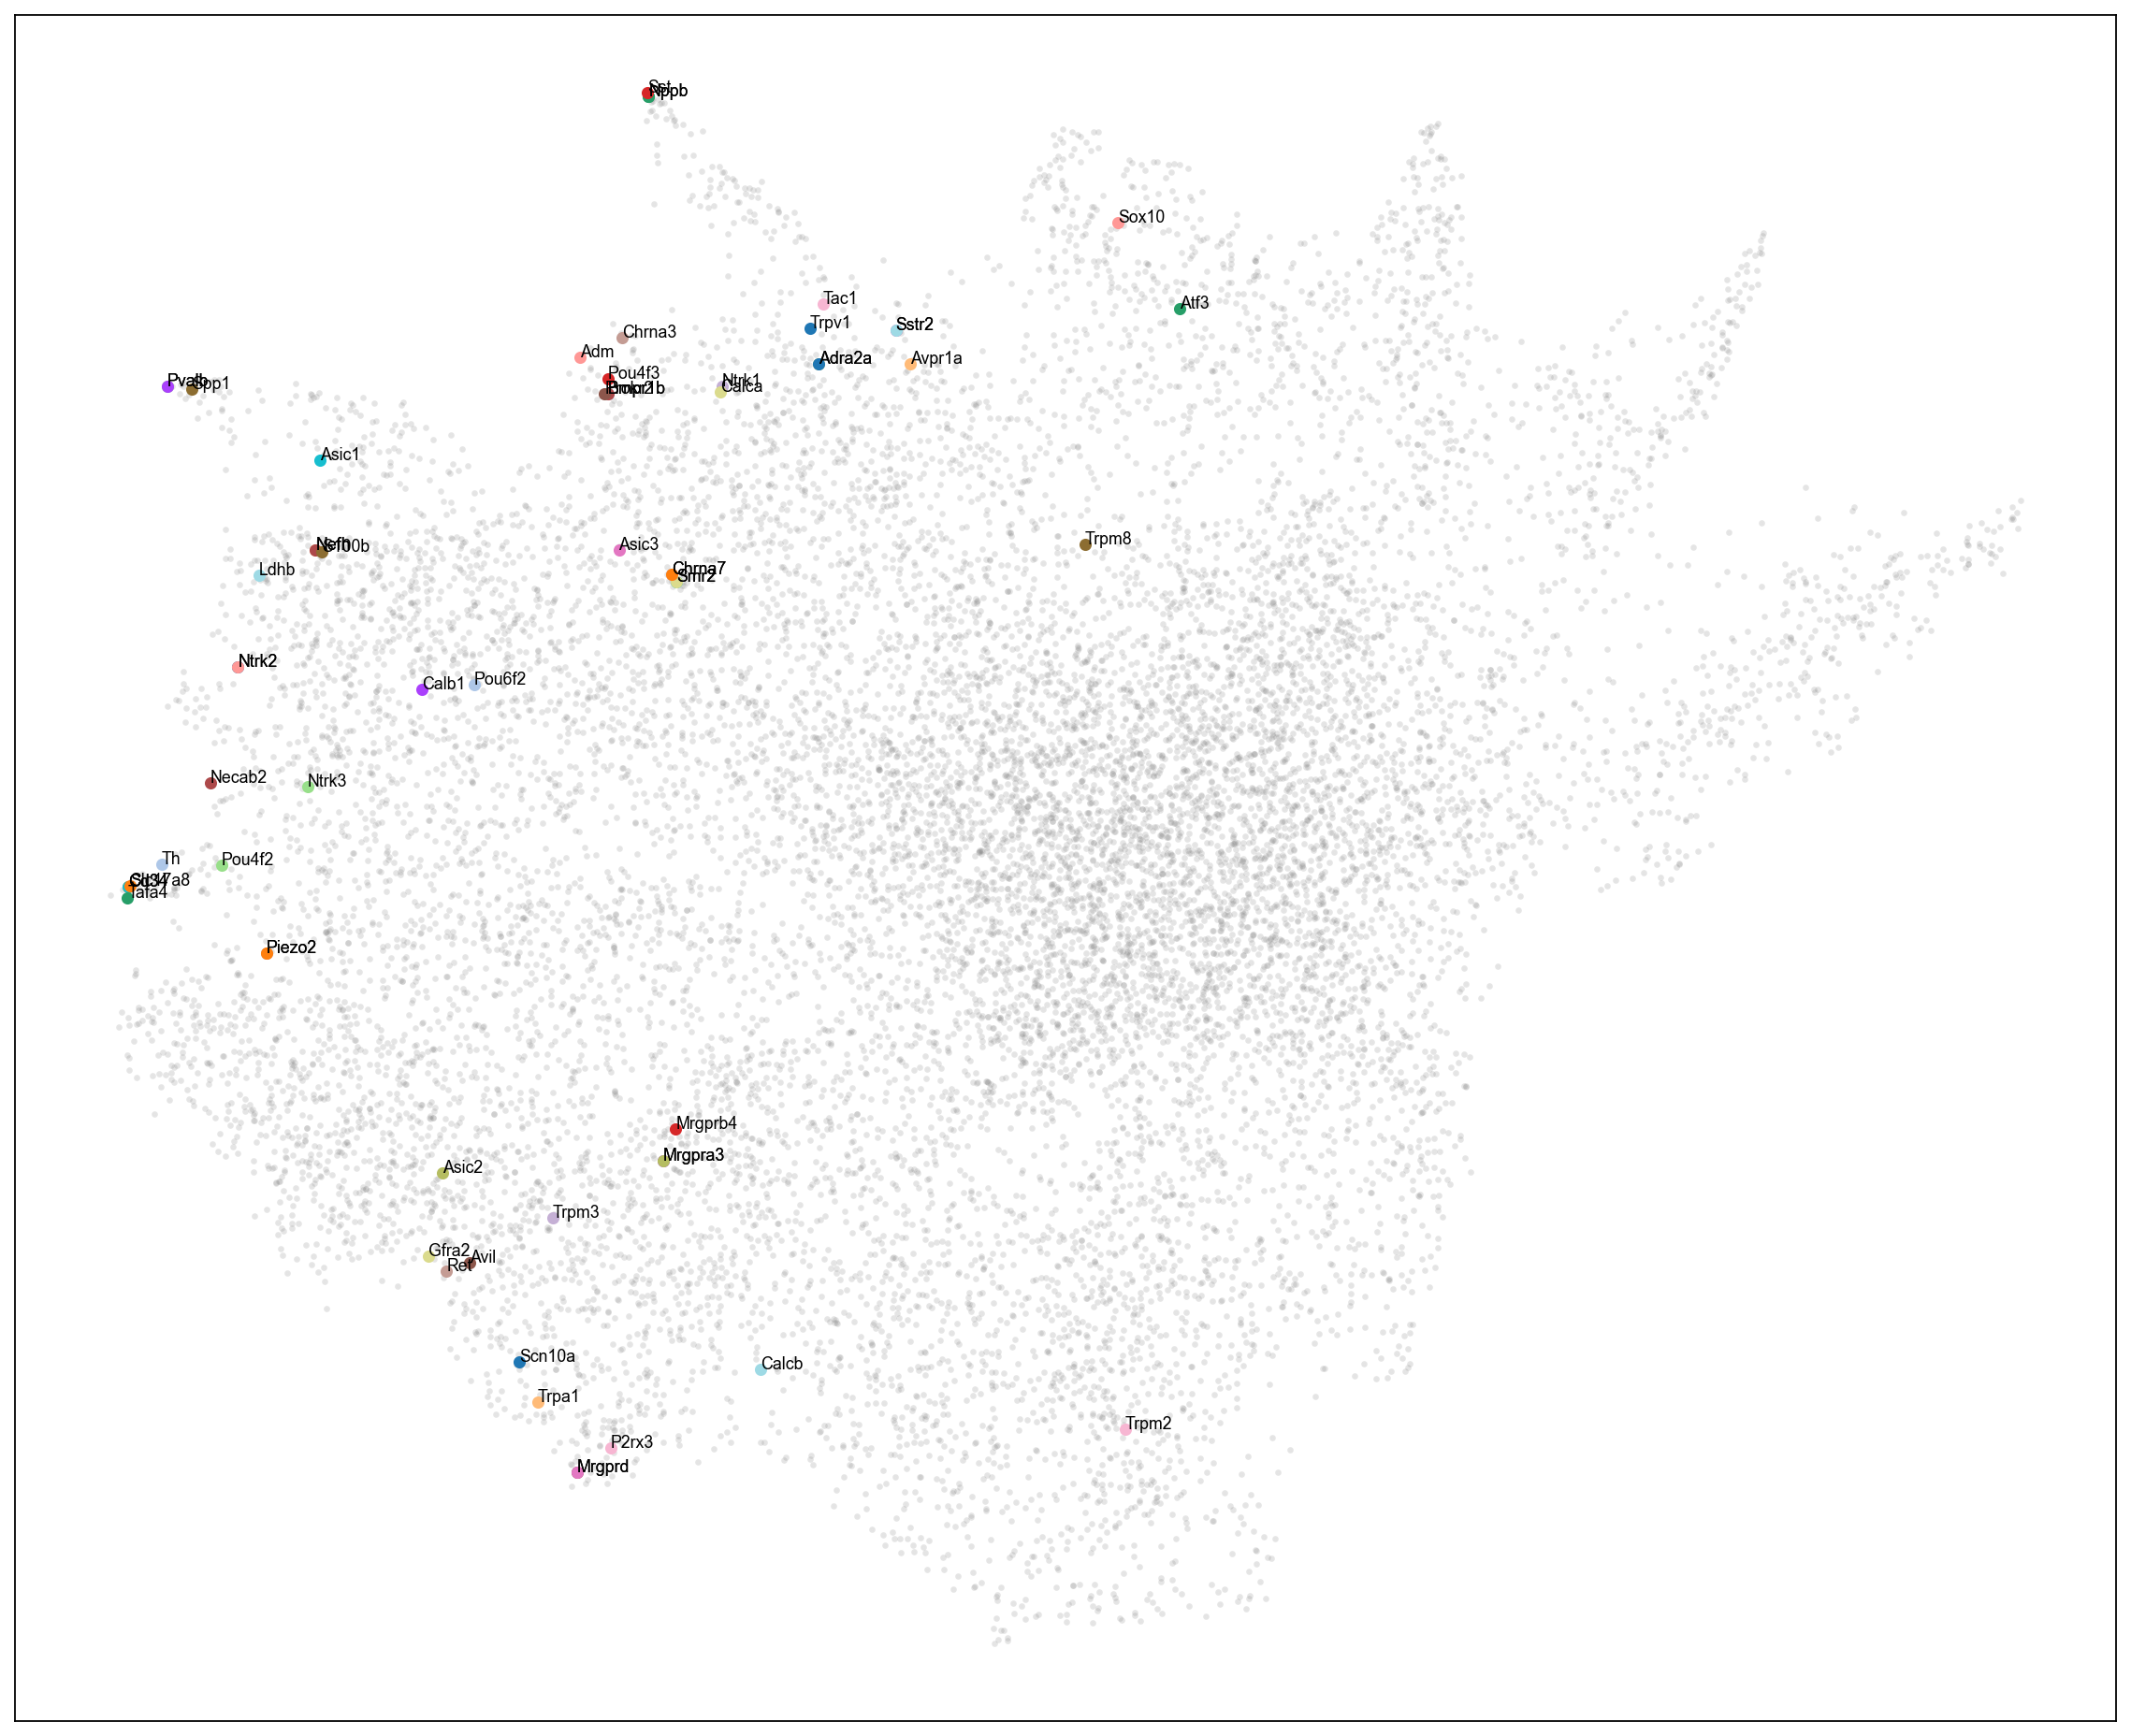

In [47]:
rcParams['figure.figsize']=(18,15)
figure, axes = plt.subplots()

axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1, c = 'gray', alpha = 0.2)
# marker_genes_plotting = ['Campari','pinch','new_stroke','ballon','AG','AD','heating','mock',
#                          'old_stroke','anal_pinch','mockw__poop',
#                         'pinch1','pinch2','pinch3', 'stroke1','stroke2']

# marker_genes_plotting = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
#                 'Bmpr1b','Nefh','Pvalb','Chrna7','Adm']

marker_genes_plotting = marker_genes

#marker_genes_plotting = ['pinch3', 'stroke1']

for interesting_gene in marker_genes_plotting:
    index = marker_genes.index(interesting_gene)
    closest_genes_for_this = closest_genes[index]
    #axes.scatter(umap_embedding[nearest_neighbors[1:,index].astype(int),0],umap_embedding[nearest_neighbors[1:,index].astype(int),1], s= 1, c = 'k')
    axes.scatter(umap_embedding[nearest_neighbors[0,index].astype(int),0],umap_embedding[nearest_neighbors[0,index].astype(int),1], s= 15)
    axes.annotate(interesting_gene, (umap_embedding[nearest_neighbors[0,index].astype(int),0], umap_embedding[nearest_neighbors[0,index].astype(int),1]),fontsize = 8, color= 'k')
axes.grid(False)
axes.set_xticks([])
axes.set_yticks([])

figure.savefig(os.path.join(figure_path , 'genes_umap_norm.png'))

In [48]:
gene = 'Th'
index= marker_genes.index(gene)
closest_genes[index]

['Th',
 'Tafa4',
 'D130079A08Rik',
 'Ighg2c',
 'Fxyd6',
 'Gm7271',
 'Cd34',
 'Slc51a',
 'Cckar',
 'Rnf112',
 'Wfdc2',
 'Hpca',
 'Kcnd3',
 'Zfp521',
 'Cdh9',
 'Spink2',
 'Slc17a8',
 'Cacna1i',
 'Gm47913',
 'Rarres1']